Import Packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
np.random.seed(1)

Load the data:

In [2]:
## Open the file for reading:
train_data = h5py.File('datasets/train_catvnoncat.h5', 'r')
test_data = h5py.File('datasets/test_catvnoncat.h5', 'r')

In [3]:
## h5py files act like a Python dictionary, thus we can check the keys:
print(list(train_data.keys()))
print(list(test_data.keys()))

['list_classes', 'train_set_x', 'train_set_y']
['list_classes', 'test_set_x', 'test_set_y']


In [4]:
## Extracting the test and train datasets:
train_set_x = np.array(train_data["train_set_x"]) # train set features (x)
train_set_y = np.array(train_data["train_set_y"]) # train set labels (y)

test_set_x = np.array(test_data["test_set_x"]) # test set features (x)
test_set_y = np.array(test_data["test_set_y"]) # test set labels (y)

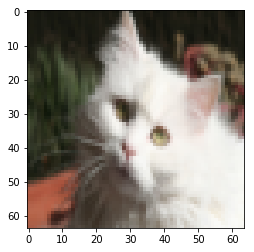

In [5]:
## Displaying a sample image, i.e. data on a 2D regular raster:
index = 102
plt.imshow(train_set_x[index]);

In [6]:
## Check dataset shapes:
print('The shape of train_set_x is:\t', train_set_x.shape)
print('The shape of train_set_y is:\t', train_set_y.shape)
print('The shape of test_set_x is:\t', test_set_x.shape)
print('The shape of test_set_y is:\t', test_set_y.shape)

The shape of train_set_x is:	 (209, 64, 64, 3)
The shape of train_set_y is:	 (209,)
The shape of test_set_x is:	 (50, 64, 64, 3)
The shape of test_set_y is:	 (50,)


In [7]:
## Number of samples (m):
m_train = train_set_y.shape[0]
m_test = test_set_y.shape[0]

In [8]:
## Reshaping Ys to (1,m):
train_set_y = train_set_y.reshape((1, m_train))
test_set_y = test_set_y.reshape((1, m_test))

In [9]:
## Reshaping Xs to (64 * 64 * 3, m):
train_set_x = train_set_x.reshape(m_train, -1).T
test_set_x = test_set_x.reshape(m_test, -1).T

## Standardizing to have all features between 0 and 1:
train_set_x = train_set_x/255.
test_set_x = test_set_x/255.

In [10]:
## Re-check dataset shapes:
print('The shape of train_set_x is:\t', train_set_x.shape)
print('The shape of train_set_y is:\t', train_set_y.shape)
print('The shape of test_set_x is:\t', test_set_x.shape)
print('The shape of test_set_y is:\t', test_set_y.shape)
print('Number of training examples:\t', m_train)
print('Number of test examples:\t', m_test)

The shape of train_set_x is:	 (12288, 209)
The shape of train_set_y is:	 (1, 209)
The shape of test_set_x is:	 (12288, 50)
The shape of test_set_y is:	 (1, 50)
Number of training examples:	 209
Number of test examples:	 50


In [11]:
## Try predicting using Logistic Regression

pass

Define Sigma and ReLU (and their derivatives):

In [12]:
## Sigmoid function:
def sigmoid(Z):
    """
    Implementing the sigmoid activation function
    
    Input:
    Z: numpy array
    
    Output:
    A: output of sigmoid(Z)
    """
    A = 1 / (1 + np.exp(-Z))
    
    assert(A.shape == Z.shape)

    return A

## ReLU functions:
def relu(Z):
    """
    Implementing the ReLU activation function
    
    Input:
    Z: numpy array
    
    Output:
    A: output of relu(Z)
    """
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)

    return A

def sigmoid_derivative(Z):
    """
    Derivative of Sigmoid activation functions (g'(z))
    
    Input:
    Z: numpy array
    
    Output:
    g_prime_Z: output of the derivtive of Sigmoid function at Z
    """
    dZ = sigmoid(Z) * (1 - sigmoid(Z))
    
    assert (dZ.shape == Z.shape)

    return dZ
    
def relu_derivative(Z):
    """
    Derivative of ReLU activation functions (g'(z))
    
    Input:
    Z: numpy array
    
    Output:
    g_prime_Z: output of the derivtive of ReLU function at Z
    """
    # Z = np.array(Z)
    dZ = np.ones(shape = Z.shape)
    dZ[Z <= 0] = 0  # dZ = 0 where z <= 0 and 1 where z > 0 
    
    assert (dZ.shape == Z.shape)

    return dZ

Deep Learning methodology to build the model:

1. Initialize parameters and define hyperparameters
2. Loop for num_iterations (Forward propagation > Compute cost > Backward propagation > Update parameters) 
3. Use trained parameters to predict labels

In here:

```python
def initialize_params(layers_dims):
    ...
    return params

def forward_prop(X, params):
    ...
    return A_L, caches

def cost_fun(A_L, Y):
    ...
    return cost

def backward_prop(A_L, Y, caches):
    ...
    return grads

def update_params(params, grads, learning_rate):
    ...
    return params
```

In [13]:
def initialize_params(layers_dims):
    """
    Initializing the network parameters b and W
    
    Input:
    layer_dims: python array (list) containing the dimensions of each layer in the network (including input layer)
    
    Output:
    params: Python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl: Weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl: Bias vector of shape (layer_dims[l], 1)
    """
    ## Number of layers:
    L = len(layers_dims) - 1
    
    ## Random initialization of weight parameters:
    params = {}
    
    for l in range(1, L + 1):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1]) #* 0.01
        params['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        assert(params['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(params['b' + str(l)].shape == (layers_dims[l], 1))

    return params

In [14]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implementing the forward propagation for each LINEAR > ACTIVATION layer

    Inout:
    A_prev: Activations from previous layer (or input data) in shape (size of previous layer, number of examples)
    W: Weights matrix for current layer as numpy array of shape (size of current layer, size of previous layer)
    b: Bias vector for current layer as numpy array of shape (size of the current layer, 1)
    activation: The type of activation function to use in current layer ("sigmoid" or "relu")

    Output:
    A: Output of the activation function 
    cache: Python dictionary containing (A, W, b, Z)
    """
    
    Z = np.dot(W, A_prev) + b
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))  
        
    if activation == 'sigmoid':
        A = sigmoid(Z)
        
    elif activation == 'relu':
        A = relu(Z)        
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))

    cache = (A_prev, W, b, Z)
    
    return A, cache



def forward_prop(X, params):
    """
    Implementing forward propagation assuming (L-1) layers with ReLU and output layer with Sigmoid activation
    
    Inout:
    X: features data in form of numpy array of shape (n, m) where n is input size and m is number of examples
    params: Initialized parmeters from output of initialize_params()
    
    Output:
    A_L: Predicted output (last post-activation value)
    cache: list of Z values (L of them, indexed from 0 to L-1)
    """    
    cache = []
    A = X
    
    ## Number of layers:
    L = int(len(params) / 2)
    
    ## Implementing forward propagation for (L-1) layers with ReLU:
    for l in range(1, L):
        A_prev = A
        A, cache_temp = linear_activation_forward(A_prev, 
                                                  params['W' + str(l)], 
                                                  params['b' + str(l)], 
                                                  activation = 'relu')
        cache.append(cache_temp)
        
     
    ## Implementing forward propagation for output layer with Sigmoid:
    A_L, cache_temp = linear_activation_forward(A, params['W' + str(L)], 
                                                params['b' + str(L)], 
                                                activation = 'sigmoid')
    cache.append(cache_temp)
    
    assert(A_L.shape == (1,X.shape[1]))

    return A_L, cache

In [15]:
def cost_fun(A_L, Y):
    """
    Calculating the cost function assuming Sigmoid activation on output layer (L)

    Inout:
    A_L: Probability vector corresponding to label predictions of shape (1, m) where m is number of examples
    Y: True "label" vector of shape (1, m)

    Output:
    cost: The cross-entropy cost
    """
    m = Y.shape[1]
    
    cost = (-1/m) * (np.dot(Y, np.log(A_L).T) + np.dot((1-Y), np.log(1-A_L).T))
    
    # Remove single-dimensional entries from the shape of an array (e.g. turn [[17]] into 17):
    cost = np.squeeze(cost) 
    assert(cost.shape == ())

    return cost

In [16]:
def linear_activation_backward(dA, cache, activation):
    """
    Implementing the backward propagation for each LINEAR > ACTIVATION layer

    Inout:
    dA: Post-activation gradient for current layer l
    cache: Python dictionary containing (A, W, b, Z)
    activation: The type of activation function to use in current layer ("sigmoid" or "relu")
    
    Output:
    dA_prev: Gradient of the cost with respect to the activation of the previous layer (l-1), same shape as A_prev
    dW: Gradient of the cost with respect to W for current layer (l), same shape as W
    db: Gradient of the cost with respect to b for current layer (l), same shape as b
    """
    
    A_prev, W, b, Z = cache
    m = A_prev.shape[1]
    
    if activation == "sigmoid":
        dZ = dA * sigmoid_derivative(Z)

            
    elif activation == "relu":
        dZ = dA * relu_derivative(Z)
        
    dA_prev = np.dot(W.T, dZ)
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)    
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)    
    
    return dA_prev, dW, db


    
def backward_prop(A_L, Y, cache):
    
    """
    Implementing backward propagation assuming (L-1) layers with ReLU and output layer with Sigmoid activation
    
    Input:
    A_L: Probability vector, output of the forward propagation forward_prop()
    Y: True "label" vector of shape (1, m)
    cache: Python dictionary containing (A_prev, W, b, Z)

    Output:
    grads: A dictionary with the gradients dA, dW and db
    """    
    
    grads = {}
    L = len(cache)
    m = A_L.shape[1]

    ## Initializing for layer L:
    dA_L = - (np.divide(Y, A_L) - np.divide(1 - Y, 1 - A_L))

    ## Implementing backward propagation for output (L-th) layer with Sigmoid:
    current_cache = cache[L-1]
    dA_prev, dW, db = linear_activation_backward(dA_L, current_cache, activation = 'sigmoid')
    grads['dA' + str(L-1)] = dA_prev
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db
    
    ## Implementing backward propagation for (L-1) layers with ReLU:
    for l in reversed(range(1, L)):
        current_cache = cache[l-1]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l)], current_cache, activation = 'relu')
        grads['dA' + str(l-1)] = dA_prev
        grads['dW' + str(l)] = dW
        grads['db' + str(l)] = db
    
    return grads

In [17]:
def update_params(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Input:
    params: Python dictionary containing parameters "W1", "b1", ..., "WL", "bL"
    grads: A dictionary with the gradients dA, dW and db, output of backward_prop()
    
    Output:
    params: Python dictionary containing updated parameters "W1", "b1", ..., "WL", "bL"
    """
    L = int(len(params) / 2)
    
    for l in range(1, L+1):
        params['W' + str(l)] = params['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] = params['b' + str(l)] - learning_rate * grads['db' + str(l)]
        
    return params

In [18]:
def predict(X, params):
    """
    Predicting the results of a L-layer neural network
    
    Input:
    X: Input examples to label
    params: Parameters of the trained model
    
    Output:
    p: Predictions for the given dataset X
    """
    m = X.shape[1]
    L = int(len(params) / 2)
    p = np.zeros((1,m))

    A_L, cache = forward_prop(X, params)    
    
    # Converting A_L to 0 and 1 predictions:
    for i in range(0, A_L.shape[1]):
        if A_L[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    return p            

In [19]:
def L_layer_NN(X, y, layers_dims, learning_rate = 0.0075, num_iterations = 3000):
    """
    Implementing the L-layer neural network with (L-1) ReLU and 1 Sigmoid activations
    
    Input:
    X: The input data as a numpy array of shape (num_px * num_px * 3, m) where m is number of examples
    y: The true "label" vector of shape (1, m)
    layers_dims: The list containing the network architecture (input size and each layer size)
    learning_rate: The learning rate of the gradient descent
    num_iterations: Number of iterations for the optimization loop
    
    Output:
    params: The parameters learnt by the model to be used for predictions
    """

    costs = []
    index = []
    
    # Parameters initialization:
    params = initialize_params(layers_dims)
    
    for i in range(0, num_iterations):

        # Forward propagation:
        A_L, cache = forward_prop(X, params)

        # Computing cost:
        cost = cost_fun(A_L, y)
    
        # Backward propagation:
        grads = backward_prop(A_L, y, cache)
 
        # Updating parameters:
        params = update_params(params, grads, learning_rate)
        
        #Printing the cost every 100 iterations:
        if i % 100 == 0:
            print ('Iteration Number:', i, '\tCost:', cost)
        if i % 100 == 0:
            index.append(i)
            costs.append(cost)

    # plot the cost
    plt.scatter(x = index, y = np.squeeze(costs).tolist())
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.show()
    
    return params

Iteration Number: 0 	Cost: 0.6822195652640717
Iteration Number: 100 	Cost: 0.5805842964515768
Iteration Number: 200 	Cost: 0.5183103150912929
Iteration Number: 300 	Cost: 0.4705407304562535
Iteration Number: 400 	Cost: 0.4335748876165664
Iteration Number: 500 	Cost: 0.38336526927301534
Iteration Number: 600 	Cost: 0.32134348345569524
Iteration Number: 700 	Cost: 0.23559322415799683
Iteration Number: 800 	Cost: 0.1606441926532505
Iteration Number: 900 	Cost: 0.12681805901038268
Iteration Number: 1000 	Cost: 0.06565100569664171
Iteration Number: 1100 	Cost: 0.03703369299186711
Iteration Number: 1200 	Cost: 0.023887069007864112
Iteration Number: 1300 	Cost: 0.017164751826209333
Iteration Number: 1400 	Cost: 0.012080249878078955
Iteration Number: 1500 	Cost: 0.009583430287411073
Iteration Number: 1600 	Cost: 0.007914358624723483
Iteration Number: 1700 	Cost: 0.006697217726814877
Iteration Number: 1800 	Cost: 0.0057784822594028435
Iteration Number: 1900 	Cost: 0.005058985259420181
Iteration

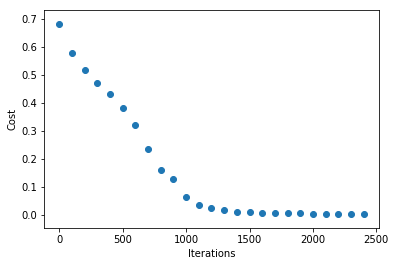

In [20]:
## Define network architecture:
layers_dims = [train_set_x.shape[0], 20, 70, 5, train_set_y.shape[0]]   ## 4-layers

parameters = L_layer_NN(train_set_x, train_set_y, layers_dims, num_iterations = 2500)

In [21]:
pred_train = predict(train_set_x, parameters)

print("The accuracy is: " + str(np.sum((pred_train == train_set_y) / train_set_y.shape[1])))

The accuracy is: 0.9999999999999998


In [22]:
pred_test = predict(test_set_x, parameters)
print("The accuracy is: " + str(np.sum((pred_test == test_set_y) / test_set_y.shape[1])))

The accuracy is: 0.78
